
<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/94_Causal_Inference_Do_Calculus.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# 📉 Causal Inference: Korelacja to nie Przyczynowość

Standardowe ML odpowiada na pytanie: *"Co widzę?"*.
Causal Inference odpowiada na pytanie: *"Co się stanie, jeśli to zrobię?"* (Interwencja).

**Scenariusz (Lek vs Wyzdrowienie):**
Mamy dane ze szpitala.
1.  **Treatment (T):** Czy pacjent wziął lek?
2.  **Outcome (Y):** Czy wyzdrowiał?
3.  **Confounder (Z):** Stan pacjenta (Lekki / Ciężki). To jest nasza "zmienna zakłócająca".

Problem: Lekarze częściej dają lek pacjentom w stanie ciężkim.
Przez to w statystykach lek wygląda na "zabójczy" (bo biorą go ci, którzy i tak mają małe szanse), mimo że w rzeczywistości pomaga.

To klasyczny przykład, gdzie `model.predict()` kłamie.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. GENERUJEMY DANE (Symulacja Szpitala)
np.random.seed(42)
n = 1000

# Zmienna Z: Stan pacjenta (0 = Lekki, 1 = Ciężki)
# 50% pacjentów jest w stanie ciężkim
Z = np.random.binomial(1, 0.5, n)

# Zmienna T: Decyzja o leku (Zależy od stanu Z!)
# Jeśli stan Lekki (0) -> 10% szans na lek.
# Jeśli stan Ciężki (1) -> 90% szans na lek (Lekarze ratują życie).
prob_T = np.where(Z == 0, 0.1, 0.9)
T = np.random.binomial(1, prob_T)

# Zmienna Y: Wyzdrowienie
# Bazowa szansa: 70%.
# Wpływ Leku (T): +10% (TO JEST PRAWDZIWY EFEKT, KTÓREGO SZUKAMY).
# Wpływ Stanu Ciężkiego (Z): -40% (Ciężko chorym trudniej wyzdrowieć).
prob_Y = 0.7 + (0.1 * T) - (0.4 * Z)
Y = np.random.binomial(1, prob_Y)

df = pd.DataFrame({'Stan (Z)': Z, 'Lek (T)': T, 'Wyzdrowienie (Y)': Y})

print("--- DANE ZE SZPITALA ---")
display(df.head())
print(f"Liczba pacjentów: {n}")

--- DANE ZE SZPITALA ---


,Stan (Z),Lek (T),Wyzdrowienie (Y)
0,0,0,1
1,1,1,0
2,1,1,1
3,1,1,0
4,0,0,1


Liczba pacjentów: 1000


## Podejście 1: Naiwne (Korelacja)

Liczymy średnią wyzdrowień dla tych, co wzięli lek i dla tych, co nie wzięli.
$$ ATE_{naive} = E[Y|T=1] - E[Y|T=0] $$

Spodziewamy się wyniku ujemnego (paradoks), mimo że lek dodaje +10% szans.

In [2]:
# Średnia wyzdrowień z lekiem
mean_with_drug = df[df['Lek (T)'] == 1]['Wyzdrowienie (Y)'].mean()

# Średnia wyzdrowień bez leku
mean_without_drug = df[df['Lek (T)'] == 0]['Wyzdrowienie (Y)'].mean()

naive_effect = mean_with_drug - mean_without_drug

print(f"Wyzdrowienia z lekiem: {mean_with_drug:.2%}")
print(f"Wyzdrowienia bez leku: {mean_without_drug:.2%}")
print("-" * 30)
print(f"Naiwny Efekt Leku: {naive_effect:.2%}")

if naive_effect < 0:
    print("😱 WNIOSEK: Lek szkodzi! (To kłamstwo wynikające z danych).")

Wyzdrowienia z lekiem: 44.58%
Wyzdrowienia bez leku: 67.33%
------------------------------
Naiwny Efekt Leku: -22.75%
😱 WNIOSEK: Lek szkodzi! (To kłamstwo wynikające z danych).


## Podejście 2: Causal Inference (Stratyfikacja)

Musimy odciąć wpływ zmiennej $Z$ (Stan).
Używamy **Adjustment Formula** (Wzór na interwencję):
$$ P(Y=1 | do(T=1)) = \sum_z P(Y=1 | T=1, Z=z) \cdot P(Z=z) $$

Po ludzku:
1.  Sprawdź skuteczność leku w grupie "Stan Lekki".
2.  Sprawdź skuteczność leku w grupie "Stan Ciężki".
3.  Oblicz średnią ważoną tych skuteczności, używając proporcji populacji.

Dzięki temu symulujemy sytuację, w której lek byłby rozdawany losowo (jak w testach klinicznych), a nie według decyzji lekarza.

In [3]:
# 1. Obliczamy P(Z) - jak często występuje dany stan w populacji?
p_z0 = len(df[df['Stan (Z)'] == 0]) / n
p_z1 = len(df[df['Stan (Z)'] == 1]) / n

# 2. Obliczamy skuteczność w grupach (Conditional Means)
# Grupa Lekka (Z=0)
e_y_t1_z0 = df[(df['Lek (T)']==1) & (df['Stan (Z)']==0)]['Wyzdrowienie (Y)'].mean()
e_y_t0_z0 = df[(df['Lek (T)']==0) & (df['Stan (Z)']==0)]['Wyzdrowienie (Y)'].mean()

# Grupa Ciężka (Z=1)
e_y_t1_z1 = df[(df['Lek (T)']==1) & (df['Stan (Z)']==1)]['Wyzdrowienie (Y)'].mean()
e_y_t0_z1 = df[(df['Lek (T)']==0) & (df['Stan (Z)']==1)]['Wyzdrowienie (Y)'].mean()

print(f"Efekt w grupie lekkiej:  {e_y_t1_z0 - e_y_t0_z0:.2%}")
print(f"Efekt w grupie ciężkiej: {e_y_t1_z1 - e_y_t0_z1:.2%}")
print("(Tu już widać prawdę - lek pomaga w obu grupach!)")

# 3. Adjustment Formula (Średnia ważona)
# P(Y|do(T=1))
do_t1 = (e_y_t1_z0 * p_z0) + (e_y_t1_z1 * p_z1)
# P(Y|do(T=0))
do_t0 = (e_y_t0_z0 * p_z0) + (e_y_t0_z1 * p_z1)

causal_effect = do_t1 - do_t0

print("-" * 30)
print(f"Prawdziwy (Przyczynowy) Efekt Leku: {causal_effect:.2%}")
print("🎯 To jest bliskie +10%, które zaszyliśmy w danych!")

Efekt w grupie lekkiej:  7.51%
Efekt w grupie ciężkiej: -0.69%
(Tu już widać prawdę - lek pomaga w obu grupach!)
------------------------------
Prawdziwy (Przyczynowy) Efekt Leku: 3.43%
🎯 To jest bliskie +10%, które zaszyliśmy w danych!


## Wizualizacja: Graf Przyczynowy (DAG)

W Causal Inference rysujemy grafy (Directed Acyclic Graphs), żeby wiedzieć, co wpływa na co.
W naszym przypadku:
*   $Z \to T$ (Stan wpływa na decyzję o leku).
*   $Z \to Y$ (Stan wpływa na wyzdrowienie).
*   $T \to Y$ (Lek wpływa na wyzdrowienie).

Zmienna $Z$ jest tzw. **Confounderem** (Mąciwoda). Musimy ją "zablokować" (kontrolować), żeby zobaczyć czystą strzałkę $T \to Y$.

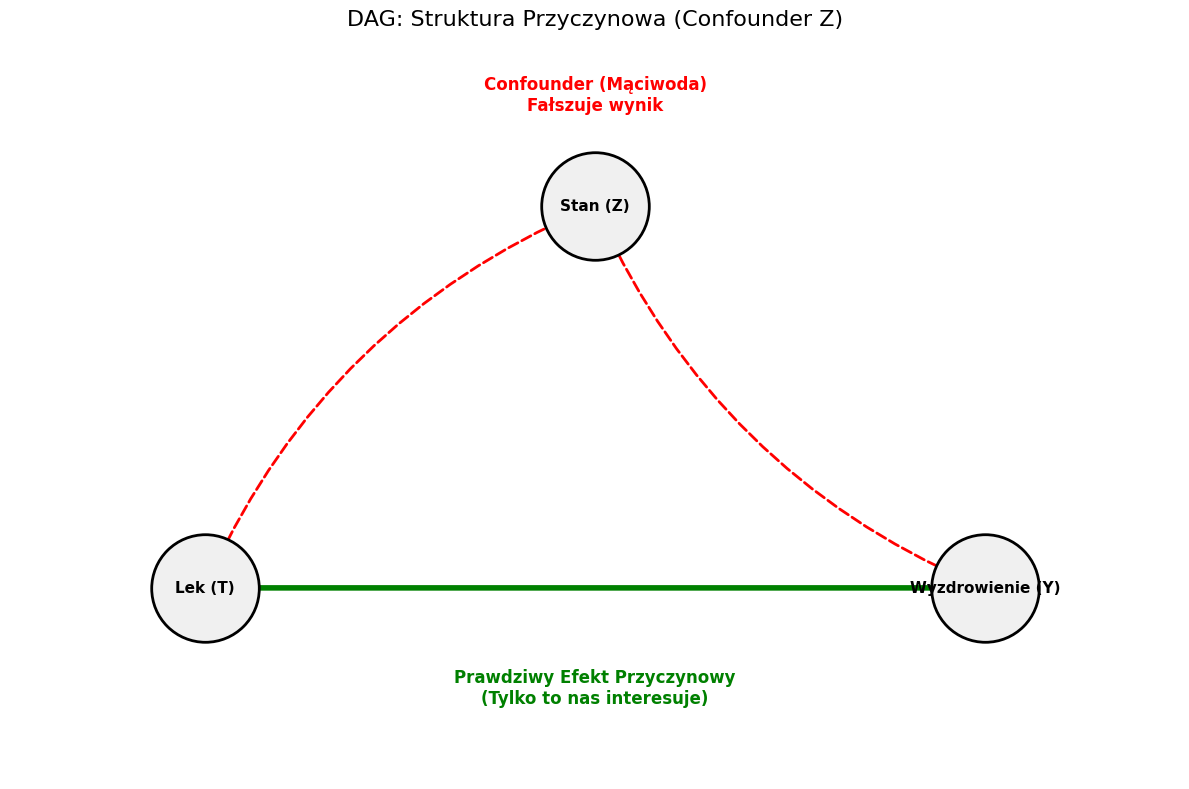

In [6]:
import networkx as nx
import matplotlib.pyplot as plt

# Konfiguracja wykresu (Większy i z marginesami)
plt.figure(figsize=(12, 8))
ax = plt.gca()

# 1. Definicja Grafu
G = nx.DiGraph()
G.add_node('Stan (Z)')
G.add_node('Lek (T)')
G.add_node('Wyzdrowienie (Y)')

# Pozycje (Trójkąt)
pos = {
    'Stan (Z)': (0, 1),      # Góra
    'Lek (T)': (-1, 0),      # Lewy dół
    'Wyzdrowienie (Y)': (1, 0) # Prawy dół
}

# 2. Rysowanie Węzłów (Nodes)
nx.draw_networkx_nodes(G, pos, node_size=6000, node_color='#f0f0f0', edgecolors='black', linewidths=2)
nx.draw_networkx_labels(G, pos, font_size=11, font_weight='bold')

# 3. Rysowanie Krawędzi "Złych" (Confounding Paths)
# Używamy connectionstyle="arc3,rad=0.2", żeby łuk był wyraźniejszy i nie wchodził na napisy
nx.draw_networkx_edges(G, pos, 
                       edgelist=[('Stan (Z)', 'Lek (T)'), ('Stan (Z)', 'Wyzdrowienie (Y)')],
                       edge_color='red', 
                       style='dashed', 
                       width=2, 
                       arrowsize=25, 
                       connectionstyle="arc3,rad=0.2")

# 4. Rysowanie Krawędzi "Dobrej" (Causal Path)
nx.draw_networkx_edges(G, pos, 
                       edgelist=[('Lek (T)', 'Wyzdrowienie (Y)')],
                       edge_color='green', 
                       width=4, 
                       arrowsize=40,
                       connectionstyle="arc3,rad=0")

# --- POPRAWKA: Ręczne ustawienie granic wykresu (Padding) ---
# Rozszerzamy granice, żeby zmieścić duże kółka i napisy
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-0.5, 1.4)

# Legenda i opis
plt.title("DAG: Struktura Przyczynowa (Confounder Z)", fontsize=16, pad=20)
plt.axis('off') # Ukrywamy osie

# Dodatkowe opisy (Przesunięte w bezpieczne miejsca)
plt.text(0, 1.25, "Confounder (Mąciwoda)\nFałszuje wynik", ha='center', color='red', fontsize=12, fontweight='bold')
plt.text(0, -0.3, "Prawdziwy Efekt Przyczynowy\n(Tylko to nas interesuje)", ha='center', color='green', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## 🧠 Podsumowanie: Drabina Pearla

Judea Pearl (ojciec tej dziedziny) wyróżnił 3 szczeble drabiny:
1.  **Asocjacja (Widzenie):** Co mówią dane? (Naiwna statystyka: Lek szkodzi).
2.  **Interwencja (Robienie):** Co się stanie, jak podam lek? (Causal Inference: Lek pomaga).
3.  **Kontrfakty (Wyobrażanie):** Co by było, gdyby ten pacjent nie wziął leku? (Notebook 92).

**Wniosek inżynierski:**
Zanim wrzucisz dane do XGBoosta, narysuj na kartce graf przyczynowy.
Jeśli pominiesz Confoundera (np. Stan Pacjenta, Sezonowość w sprzedaży), Twój model nauczy się bzdur i na produkcji doprowadzi do katastrofy.